In [1]:
from braingeneers import analysis
import braingeneers.data.datasets_electrophysiology as ephys
import braingeneers.utils.smart_open_braingeneers as smart_open
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from braingeneers.analysis import plot
from braingeneers.analysis import single_unit
import pickle
plt.style.use('default')

In [2]:
# rec_path = "/home/kang/disk/Opto/20230510_ucsf/hc52_chip18790_rec51023_1.raw.h5"
# file_name = "hc52_chip18790_rec51023_1.raw.h5"

In [3]:
rec_path = "/home/kang/disk/Opto/20230402_ucsf/2023_04_04_hc328_hckcr1-2_3.raw.h5"
file_name = "2023_04_04_hc328_hckcr1-2_3.raw.h5"

In [4]:
_, _, _, raster_df = ephys.get_info_maxwell(rec_path)
stim_pairs = ephys.load_gpio_maxwell(rec_path)
stim_pairs = stim_pairs[:-1].reshape(len(stim_pairs)//2, 2)

Odd number of GPIO events can't be paired. Here returns all the events.


In [5]:
raster_df

,channel,frameno,amplitude
0,959,-0.07915,-4.734530
1,850,-0.07915,-5.315370
2,910,-0.07915,-5.235429
3,298,-0.07910,-4.801906
4,962,-0.07910,-4.280422
...,...,...,...
297987,1015,300.07895,-3.005912
297988,326,300.07895,-4.030295
297989,150,300.07895,-3.564702
297990,571,300.07895,-3.626231


In [6]:
cluster_agg = raster_df.groupby("channel").agg({"frameno": lambda x: list(x)})
thres_times = cluster_agg["frameno"].to_numpy()
# thres_times = [np.array(thres_times[i]) for i in range(len(thres_times))]
print(thres_times)
spike_times = np.sort(np.hstack(thres_times))
# print(len(spike_times), spike_times)

[list([2.41285, 4.90605, 5.26635, 7.23105, 10.3888, 10.8532, 11.20565, 11.71265, 11.93415, 12.1602, 12.37565, 12.68125, 12.92855, 13.1681, 13.4933, 13.8261, 14.3549, 14.76855, 14.93065, 15.8504, 16.1295, 16.1945, 16.9464, 19.1057, 19.13845, 19.1752, 20.3748, 32.22855, 32.3924, 32.5197, 33.2421, 33.7795, 34.00185, 34.2352, 34.5549, 34.97505, 35.1386, 35.72565, 35.89905, 36.2087, 36.39665, 36.8479, 37.1697, 37.62265, 37.7405, 37.98155, 38.4974, 39.0688, 39.5291, 39.77275, 40.0117, 41.0037, 41.44075, 41.71465, 42.27655, 42.45125, 42.66515, 42.7958, 43.32695, 43.666, 44.07935, 44.44295, 44.7244, 45.34785, 45.6933, 45.94835, 46.47635, 46.7317, 47.3079, 47.75495, 48.0247, 48.38295, 49.0263, 49.4144, 49.69625, 49.91705, 52.0294, 52.11165, 52.6143, 52.82225, 53.30015, 53.42795, 53.5527, 53.75835, 54.0896, 54.3084, 54.6404, 54.7593, 54.9121, 55.0391, 55.1504, 55.3479, 55.5726, 55.9823, 56.4952, 56.92255, 57.015, 57.37065, 57.53215, 57.65675, 58.19155, 58.38395, 58.6513, 58.82995, 58.9756, 59.17

In [7]:
cluster_agg = raster_df.groupby("channel").agg({"frameno": lambda x: list(x)})
thres_times = cluster_agg["frameno"].to_numpy()
# thres_times = [np.array(thres_times[i]) * 1000.0 for  i in range(len(thres_times))]
bin_size = 1 # second
spike_times = np.sort(np.hstack(thres_times))
print(spike_times)
bins = np.arange(0, spike_times[-1]+bin_size, bin_size)
print(len(bins))
print(spike_times[-1], bins[-1])
count = np.histogram(spike_times, bins)[0]

[-7.9150000e-02 -7.9150000e-02 -7.9150000e-02 ...  3.0007895e+02
  3.0007895e+02  3.0007900e+02]
302
300.079 301.0


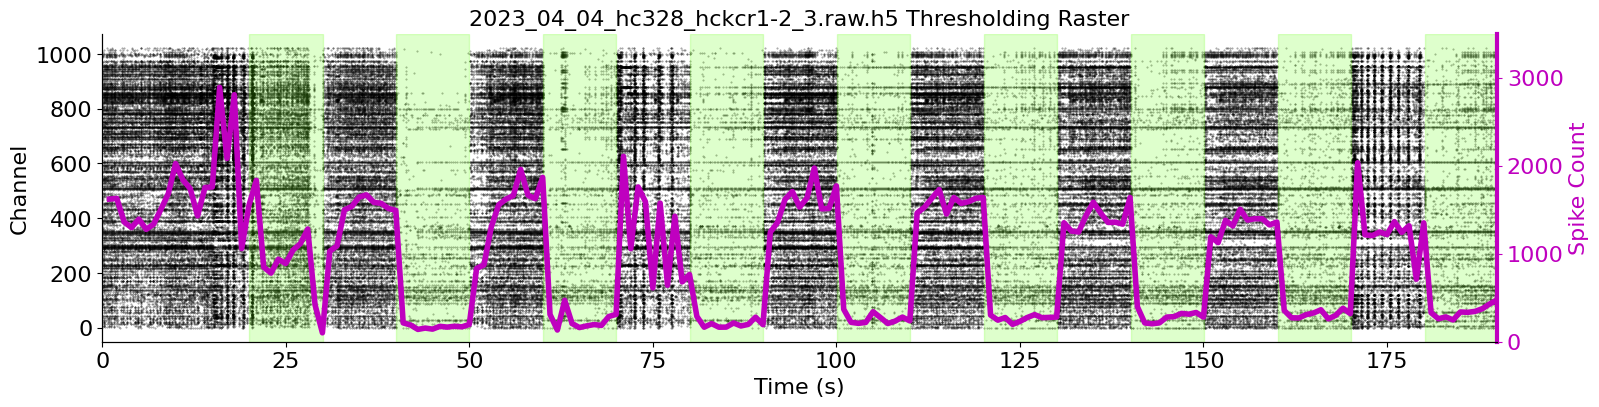

In [11]:
fig, axs = plt.subplots(figsize=(18, 4))
plt.title(file_name + " Thresholding Raster", fontsize=16)
axs.scatter(raster_df['frameno'], raster_df['channel'], s=0.2, color='k', alpha=0.4)
for stim in stim_pairs:
    axs.axvspan(stim[0], stim[1], color="#5EFF00", alpha=0.2)

axs.set_xlabel("Time (s)", fontsize=16)
axs.set_ylabel("Channel", fontsize=16)
axs.spines['top'].set_visible(False)
# axs.axvline(x=30, color="b", linewidth=3, label="Bicuculline")
# axs.axvline(x=80, color="g", linewidth=3, label="Light")
# axs.legend(loc="upper right", fontsize=12)
axs.xaxis.set_tick_params(labelsize=16)
axs.yaxis.set_tick_params(labelsize=16)

axs1 = axs.twinx()
axs1.plot(bins[1:], count, linewidth=4, color='m')
axs1.yaxis.set_tick_params(labelsize=16)
axs1.spines['top'].set_visible(False)
axs1.get_xaxis().set_visible(False)
# axs1.yaxis.set_major_locator(MaxNLocator(integer=True))
axs1.set_ylabel("Spike Count", fontsize=16, color='m')
axs1.tick_params(left=False, right=True, labelleft=False, labelright=True,
                bottom=False, labelbottom=True)
axs1.spines['top'].set_visible(False)
axs1.spines['right'].set_color('m')
axs1.spines['right'].set_linewidth(3)
axs1.tick_params(axis='y', colors='m')
axs1.set_xlim(0, 190)
axs1.set_ylim(0, 3500)
# plt.savefig(file_name + "_Thresholding_Raster.png", dpi=300)
# plt.show()
plt.savefig("closed_loop_spike_count_seizure_0404_190s.svg", dpi=300)
plt.savefig("closed_loop_spike_count_seizure_0404_190s.png", dpi=300)